In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import cv2
import os
import time
import string
from random import choice, sample
from IPython.display import clear_output

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPool1D, Dense, Embedding, GRU, \
    Bidirectional, Concatenate, Lambda, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.data_utils import Sequence

from PIL import Image

from helper_functions import *

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
print(tf.__version__)

1.11.0


In [3]:
data = pd.read_csv('/data/data_for_thevin/claim_split/imbag_to_image_id_mapping_with_part_scores.csv')

In [4]:
fbumper_ids = list(data.loc[data['fbumper'] > 0.5, 'image_id'])

In [ ]:
fbumper_ground = pd.read_csv('/data/data_for_thevin/clean_train_val_test_set/fbumper/fbumper_ud.csv')
ground_truths = fbumper_ground.set_index('image_id').loc[fbumper_ids, 'fbumper:replace'].reset_index(inplace=False)

In [6]:
ground_truths = ground_truths.dropna()

In [7]:
img_ids = ground_truths['image_id'].values
ground_trths = ground_truths['fbumper:replace'].values

In [8]:
len(img_ids) == len(ground_trths)

True

In [11]:
sample_dict = {img_ids[i] : ground_trths[i] for i in range(len(img_ids))}

In [13]:
len(sample_dict) == len(img_ids)

True

In [14]:
import pickle

with open('/data/thevin/sample_data_file_fbumper_ground_truths.pickle', 'wb') as handle:
    pickle.dump(sample_dict, handle)

# Classification

In [3]:
import pickle

with open('/data/thevin/sample_data_file_fbumper_ground_truths.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [4]:
img_ids = list(dataset.keys())
labels = list(dataset.values())

In [5]:
from collections import Counter

cnt = Counter(labels)
class_weights = dict(cnt)

cnt

Counter({0.0: 45223, 1.0: 177617})

In [6]:
pos_images = [img_ids[i] for i, label in enumerate(labels) if label == 1]
neg_images = [img_ids[i] for i, label in enumerate(labels) if label == 0]

pos_labels = [1]*len(pos_images)
neg_labels = [0]*len(neg_images)

In [7]:
pos_images_sample = sample(pos_images, len(neg_labels))

In [8]:
pos_labels_sample = [1]*len(pos_images_sample)

In [9]:
new_img_ids = pos_images_sample + neg_images
new_labels = pos_labels_sample + neg_labels

In [10]:
len(new_img_ids) == len(new_labels)

True

CPU times: user 82.5 ms, sys: 23.7 ms, total: 106 ms
Wall time: 122 ms


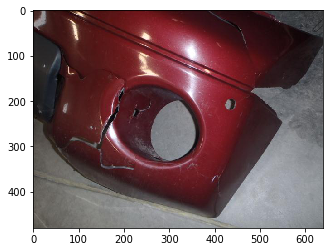

In [11]:
%%time
img = np.array(Image.open(("/data/data_for_thevin/data_for_thevin/images/{}.jpg").format(new_img_ids[1])))
#img_array = np.array(img)
plt.imshow(img)

CPU times: user 48 ms, sys: 44 ms, total: 92 ms
Wall time: 30 ms


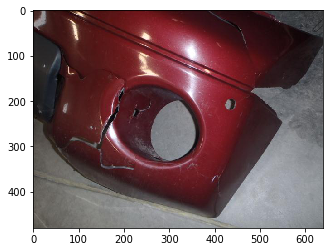

In [12]:
%%time
img = mpimg.imread(("/data/data_for_thevin/data_for_thevin/images/{}.jpg").format(new_img_ids[1]))
plt.imshow(img)

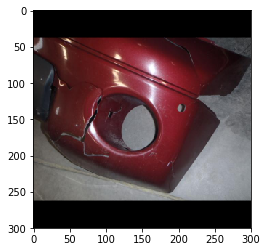

In [13]:
plt.imshow(pad_and_resize_imgs(img))

In [14]:
#Split the data into train and val
from sklearn.model_selection import train_test_split

idx_list = list(range(len(new_labels)))
train_idx, test_val_idx = train_test_split(idx_list, test_size = 0.8, shuffle = True, random_state = 2020)
val_idx, test_idx = train_test_split(test_val_idx, test_size = 0.5, shuffle = True, random_state = 2020)

train_dataset = {new_img_ids[i] : new_labels[i] for i in train_idx}
val_dataset = {new_img_ids[i] : new_labels[i] for i in val_idx}
test_dataset = {new_img_ids[i] : new_labels[i] for i in test_idx}

In [15]:
img_rows = 300
img_cols = 300

def generator(dataset, batch_size):
    img_id_list  = list(dataset.keys())
    
    i            = 0
    image_folder = os.path.join("/data/thevin/",'fbumper_classification')
    indexes = list(range(len(img_id_list)))
    while True:
        batch_indexes = sample(indexes, batch_size)
        
        batch_ids = [img_id_list[i] for i in batch_indexes]
        batch_images = [mpimg.imread(os.path.join(image_folder,  "{}.jpg".format(i))) for i in batch_ids]
        
        batch_labels = [dataset[i] for i in batch_ids]
        
        batch_images = np.array([preprocess_input(pad_and_resize_imgs(x)) for x in batch_images])
        batch_labels = np.array(batch_labels)

        yield batch_images, batch_labels

In [16]:
def generator_2(dataset, batch_size):
    img_id_list  = list(dataset.keys())
    image_folder = os.path.join("/data/thevin/",'fbumper_classification')
    indexes = list(range(len(img_id_list)))
    batches = chunker(indexes, batch_size, shuffle = True)
    
    while True:
        for batch in batches:
            
            batch_ids = [img_id_list[i] for i in batch]
            batch_images = [mpimg.imread(os.path.join(image_folder,  "{}.jpg".format(i))) for i in batch_ids]
            
            batch_labels = [dataset[i] for i in batch_ids]
            
            batch_images = np.array([preprocess_input(pad_and_resize_imgs(x)) for x in batch_images])
            batch_labels = np.array(batch_labels)
            
            yield batch_images, batch_labels

In [17]:
def generator_3(dataset, batch_size, shuffle_batches = True):
    img_id_list  = list(dataset.keys())
    image_folder = os.path.join("/data/data_for_thevin/data_for_thevin/", "images")
    indexes = list(range(len(img_id_list)))
    
    while True:
        
        batches = chunker(indexes, batch_size, shuffle = shuffle_batches)
        
        for batch in batches:
            
            batch_ids = [img_id_list[i] for i in batch]
            batch_images = [np.array(Image.open(os.path.join(image_folder,  "{}.jpg".format(i)))) for i in batch_ids]
            
            batch_labels = [dataset[i] for i in batch_ids]
            
            batch_images = np.array([preprocess_input(pad_and_resize_imgs(x)) for x in batch_images])
            batch_labels = np.array(batch_labels)
            
            yield batch_images, batch_labels

In [18]:
%%time
next(generator_3(train_dataset, 128))

CPU times: user 1.7 s, sys: 637 ms, total: 2.34 s
Wall time: 2.68 s


(array([[[[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         ...,
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -1

In [19]:
def image_model(lr=0.00001):
    input_1 = Input(shape=(None, None, 3))

    base_model = ResNet50(weights='imagenet', include_top=False)

    x1 = base_model(input_1)
    x1 = GlobalMaxPool2D()(x1)

    dense_1 = Dense(50, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)
    
    dense_2 = Dense(1, activation = 'sigmoid', name = 'dense_image_2')
    
    x1 = dense_2(x1)

    model = Model([input_1], x1)

    model.compile(loss='binary_crossentropy', optimizer = Adam(lr), metrics =['accuracy'])

    model.summary()

    return model

In [20]:
model = image_model()

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense_image_1 (Dense)        (None, 50)                102450    
_________________________________________________________________
lambda (Lambda)              (None, 50)                0         
_________________________________________________________________
dense_image_2 (Dense)        (None, 1)                 51        
Total params: 23,690,213
Trainable params: 23,637,093
Non-trainable params: 53,120
___________________________________________________________

In [22]:
file_path = "classification_model_balanced_64.h5"
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5)
reduce_ = ReduceLROnPlateau(monitor="val_acc", mode='auto', patience=10, min_lr=1e-7)

history = model.fit_generator(generator_3(train_dataset, BATCH_SIZE),
                    use_multiprocessing=False,
                    validation_data = generator_3(val_dataset, BATCH_SIZE), epochs=300, max_queue_size = 100,
                    verbose=1, workers = 10, steps_per_epoch=np.ceil(len(train_dataset)/BATCH_SIZE), 
                    validation_steps=np.ceil(len(val_dataset)/BATCH_SIZE), callbacks=[es, checkpoint, reduce_])
model.save_weights(file_path)

Epoch 1/300
565/566 [============================>.] - ETA: 0s - loss: 0.6702 - acc: 0.6348
Epoch 00001: val_acc improved from -inf to 0.69841, saving model to classification_model_balanced_64.h5
566/566 [==============================] - 1149s 2s/step - loss: 0.6702 - acc: 0.6347 - val_loss: 0.6426 - val_acc: 0.6984
Epoch 2/300
565/566 [============================>.] - ETA: 0s - loss: 0.6151 - acc: 0.7128
Epoch 00002: val_acc improved from 0.69841 to 0.71756, saving model to classification_model_balanced_64.h5
566/566 [==============================] - 735s 1s/step - loss: 0.6149 - acc: 0.7129 - val_loss: 0.5948 - val_acc: 0.7176
Epoch 3/300
565/566 [============================>.] - ETA: 0s - loss: 0.5765 - acc: 0.7267
Epoch 00003: val_acc improved from 0.71756 to 0.72246, saving model to classification_model_balanced_64.h5
566/566 [==============================] - 751s 1s/step - loss: 0.5766 - acc: 0.7267 - val_loss: 0.5758 - val_acc: 0.7225
Epoch 4/300
565/566 [==================

In [23]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


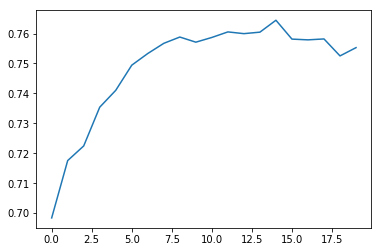

In [24]:
plt.plot(history.history['val_acc'])

In [25]:
file_path = "classification_model_balanced.h5"
BATCH_SIZE = 16

model.load_weights(file_path, by_name = True)

In [26]:
loss, acc = model.evaluate_generator(generator_3(test_dataset, BATCH_SIZE, True), use_multiprocessing=True, verbose = 1, steps=np.ceil(len(test_dataset)/BATCH_SIZE))

2262/2262 [==============================] - 780s 345ms/step


In [27]:
print("Test Accuracy : {}".format(acc))

Test Accuracy : 0.7604687802316261


In [28]:
predictions = model.predict_generator(generator_3(test_dataset, BATCH_SIZE, False), steps = np.ceil(len(test_dataset)/BATCH_SIZE), max_queue_size=100, workers = 10, verbose = 1)

2262/2262 [==============================] - 518s 229ms/step


In [29]:
def accuracy(preds, true):
    total = 0
    for i, pred in enumerate(preds):
        if pred > 0.5:
            bin_label = 1
        else:
            bin_label = 0
        if true[i] == bin_label:
            total += 1
            
    acc = total / len(preds)
    return acc

In [30]:
def keras_acc(y_pred, y_true):
    acc = K.mean(K.equal(y_true, K.round(y_pred)))
    return acc

In [31]:
len(test_dataset.values()) == len(predictions)

True

In [32]:
accuracy(predictions, list(test_dataset.values()))

0.7604687802316261

In [33]:
pos_preds = []
neg_preds = []

for i, truth in enumerate(list(test_dataset.values())):
    if truth == 1:
        pos_preds.append(predictions[i])
    else:
        neg_preds.append(predictions[i])

In [34]:
pos_acc = accuracy(pos_preds, [1]*len(pos_preds))
neg_acc = accuracy(neg_preds, [0]*len(neg_preds))

In [35]:
pos_acc, neg_acc

(0.7306693196263748, 0.7902797744111467)

In [36]:
np.mean([pos_acc, neg_acc])

0.7604745470187608